In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

2023-05-13 00:14:50.543233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise 
    return time, series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
steps_ahead = 10
time, series = generate_time_series(10000, n_steps + steps_ahead)

In [4]:
time.shape, series.shape

((60,), (10000, 60, 1))

In [5]:
# 7k/10k for training set
X_train, y_train = series[:7000, :n_steps], series[:7000, -steps_ahead:, 0]

# Next 2k/10k for validation set
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -steps_ahead:, 0]

# Next 1k/10k for test set
X_test, y_test = series[9000:, :n_steps], series[9000:, -steps_ahead:, 0]

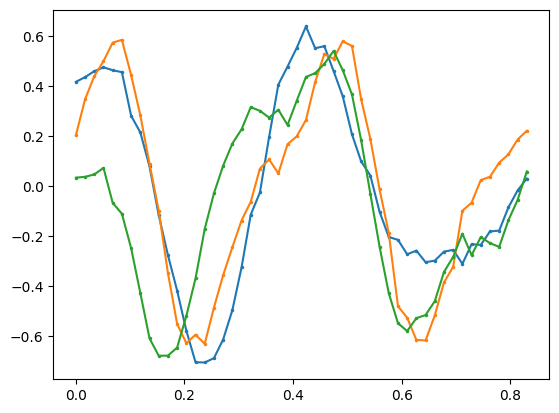

In [6]:
# There are 7K TS data, plotting only 3 of them
plt.plot(time[:n_steps], X_train[0, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[1, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[2, :, 0], marker='.', markersize=3)

In [7]:
print("Train ", X_train.shape, y_train.shape)
print("Valid ", X_valid.shape, y_valid.shape)
print("Test ", X_test.shape, y_test.shape)

Train  (7000, 50, 1) (7000, 10)
Valid  (2000, 50, 1) (2000, 10)
Test  (1000, 50, 1) (1000, 10)


### RNN with 3 layers of 20 cells and outputs 20 TS data

In [8]:
# sequence-to-vector RNN

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), 
    keras.layers.Dense(steps_ahead)
])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=30)

Epoch 1/30


2023-05-13 00:14:55.949877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


219/219 [==============================] - 3s 10ms/step - loss: 0.0560 - accuracy: 0.4149
Epoch 2/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0239 - accuracy: 0.5431
Epoch 3/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0173 - accuracy: 0.5701
Epoch 4/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0153 - accuracy: 0.5991
Epoch 5/30
219/219 [==============================] - 2s 11ms/step - loss: 0.0139 - accuracy: 0.6096
Epoch 6/30
219/219 [==============================] - 3s 12ms/step - loss: 0.0124 - accuracy: 0.6210
Epoch 7/30
219/219 [==============================] - 3s 13ms/step - loss: 0.0118 - accuracy: 0.6223
Epoch 8/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0111 - accuracy: 0.6289
Epoch 9/30
219/219 [==============================] - 2s 11ms/step - loss: 0.0109 - accuracy: 0.6304
Epoch 10/30
219/219 [==============================] - 2s 11ms/step - loss: 0.0103 - accuracy: 0.6329
E

In [9]:
#sequence-to-sequence RNN
# Need to handle differently


# Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors for step_ahead in range(1, 10 + 1):
# Y[:, :, steps_ahead - 1] = series[:, steps_ahead:steps_ahead + n_steps, 0]

# y_train = Y[:7000]
# y_valid = Y[7000:9000]
# y_test = Y[9000:]


# model = keras.models.Sequential([
#     keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
#     keras.layers.SimpleRNN(20, return_sequences=True), 
#     keras.layers.TimeDistributed(keras.layers.Dense(steps_ahead))
# ])

# optimizer = keras.optimizers.Adam(lr=0.01)
# model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])
# model.fit(X_train, y_train, epochs=30)

In [10]:
y3 = model.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [11]:
print(y3.shape)
y3[0], y3[1]

(1000, 10)


(array([-0.6080451 , -0.5954595 , -0.5396227 , -0.405381  , -0.20222132,
         0.04840449,  0.26225758,  0.4226058 ,  0.5427667 ,  0.6436538 ],
       dtype=float32),
 array([ 0.17563318,  0.07323462, -0.07498787, -0.2613402 , -0.40353936,
        -0.5265589 , -0.6147625 , -0.6710591 , -0.70289904, -0.675934  ],
       dtype=float32))

In [12]:
# correct way to extract first column

y3[:].shape, y_test.shape, X_train[0, :, 0].shape

((1000, 10), (1000, 10), (50,))

In [13]:
np.mean(keras.losses.mean_squared_error(y_test, y3[:, [0]]))

0.21500567

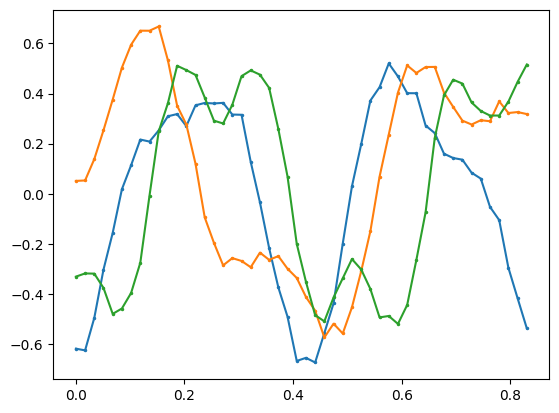

In [19]:
X_train[0, :, 0].shape, X_test[0, :, 0].shape
plt.plot(time[:n_steps], X_test[0, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_test[1, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_test[2, :, 0], marker='.', markersize=3)

In [15]:
#print(X_test[:, :, 0].shape, y3.shape)
res = np.append(X_test[:, :, 0], y3, axis=1)

def plotItem(item):
    res[item].shape, len(res[item]) , X_test[item, :, 0].shape, len(X_test[item, :, 0])
    line_space = np.linspace(0, 1, 60)
    plt.plot(line_space[:50], res[item][:50], marker='.', markersize=3)
    plt.plot(line_space[49:], res[item][49:], marker='*', markersize=3)

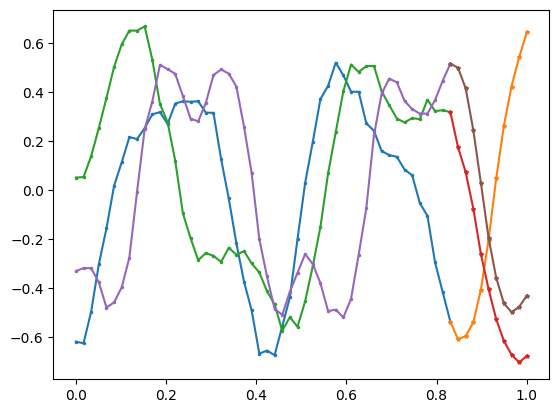

In [18]:
plotItem(0)
plotItem(1)
plotItem(2)
